In [1]:
%matplotlib inline


import sys
sys.path.append('C:/Users/Bukacek/scripts')
# from LD import LD
import numpy as np
from scipy import constants as c
import math as m
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt

yellow='#ffb200'
red='#DD5544'
blue='#0284C0'

folder='C:/Users/Bukacek/OneDrive - UFE/thesis/diplomka/prism_setup/'
# folder = 'C:/Users/jabuk/Documents/jaderka/diplomka/images_jup/'
# folder = 'C:/Users/Bukacek/OneDrive - UFE/thesis/diplomka/git/images_jup/'

In [2]:
matplotlib.rc('font', family='serif') 
matplotlib.rc('font', serif='Palatino Linotype') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 24})

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Palatino Linotype'
matplotlib.rcParams['mathtext.it'] = 'Palatino Linotype:italic'
matplotlib.rcParams['mathtext.bf'] = 'BiPalatino Linotype:bold'

In [3]:
class Permeability():
    def __init__(self):
        f= open('gold_pcgrate.txt', 'r')
        contents=f.readlines()

        self.wavelength=[]
        self.epsilon=[]
        self.real=[]
        self.imag=[]

        for line in contents[:-1]:
            line_split=line.split('\t')
            if 0.3<float(line_split[0])<1.5:
                self.wavelength.append(float(line_split[0])/1e6)
                
                eps=(float(line_split[1])+1j*float(line_split[2]))**2
                self.epsilon.append(eps)
                self.real.append(np.real(eps))
                self.imag.append(np.imag(eps))
        
        k=3
        self.sreal=interp1d(self.wavelength, self.real, kind='linear')
        self.simag=interp1d(self.wavelength, self.imag, kind='linear')

    def eps(self, lm):
        return self.sreal(lm)+1j*self.simag(lm)

In [4]:
metal=Permeability()
metal.eps(750e-9)**0.5
epd=1.33**2

print(metal.eps(750e-9))

(-21.026305842105266+1.5468600000000001j)


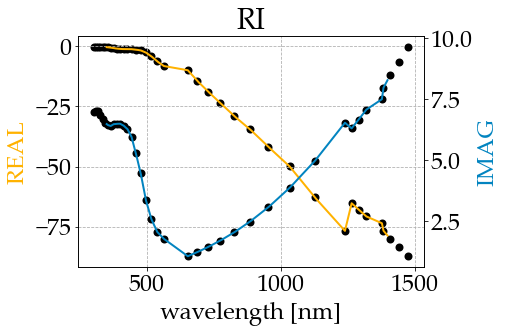

In [5]:
wls=[i/1e9 for i in range(350, 1400, 1)]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('RI')
axes.set_xlabel('wavelength [nm]')
axes.set_ylabel('REAL', color=yellow)
# axes.set_yscale('log')
axesI = axes.twinx()
axesI.set_ylabel('IMAG', color=blue)

axes.scatter([m*1e9 for m in metal.wavelength], metal.real, color='k', linewidth=2)
axes.plot([w*1e9 for w in wls], np.real(metal.eps(wls)), color=yellow, linewidth=2)


axesI.scatter([m*1e9 for m in metal.wavelength], metal.imag, color='k', linewidth=2)
axesI.plot([w*1e9 for w in wls], np.imag(metal.eps(wls)), color=blue, linewidth=2)
# axes.legend(loc=1)


* epd = $\epsilon_{dielectricum}$
* epm = $\epsilon_{metal}$
* epp = $\epsilon_{plasmon}$

$ \Re\left[ \beta \right] = k_0\sin \Theta \pm\nu g \implies g = \frac{2\pi}{\Lambda} = \frac{\Re\left[ \beta \right]}{\nu}\\ \implies \Lambda=\frac{2 \pi \nu}{\Re\left[ \beta \right]}; \nu=1, 2, ...$

$\beta=k_0 \sqrt{\frac{\epsilon_1\epsilon_2}{\epsilon_1+\epsilon_2}}$

In [12]:
def betavector(lm):
    k0=2*m.pi/lm
#     epd=1.333**2 #water
    epm=metal.eps(lm)
    epm=epm.conjugate()
    epp=epd*epm/(epd+epm)
    beta=k0*(epp**0.5)
    return beta

def prism_angle(alfa_in):
    # input in radians
    # input: angle of incidence on the golden surface
    # output: angle of incidence on the prism
    alfa_4=alfa_in
    theta=62/180*m.pi
    n1=1       #air
    n2=1.51    #prism
    n3=1.51    #glass slide
#     alfa_out=m.asin(n2/n1*m.sin(m.asin(n3/n2*m.sin(alfa_4))-theta))
    alfa_out=m.asin(n2/n1*m.sin(theta-alfa_in))
    return alfa_out/m.pi*180

def setup_angle(alfa_in):
    theta=62
    return theta-prism_angle(alfa_in)
#     return prism_angle(alfa_in)+90-theta

    
def spr_info(lm, p=False):
    
    Theta=62/180*m.pi
    k0=2*m.pi/lm
#     epd=1.333**2 #water
#     epd=1 #air

    epm=metal.eps(lm)
    epm=epm.conjugate()
    epp=epd*epm/(epd+epm)
    na=1
    npr=1.51
    n_slide=1.51
    
    beta=betavector(lm)
    
    
    kz=(beta**2-epd*(k0)**2)**0.5
    alfa_in=m.asin(np.real(beta)/k0/n_slide)
    alfa1=prism_angle(alfa_in)
    alfa=setup_angle(alfa_in)
    

    if p:
        print(lm*1e9)
        print(beta)
        
        print('n = {:.3f}'.format(beta/k0))

        print('lambda_p= {:.3f}'.format(2*m.pi/beta.real*1e9))
        print('L= {:.3f} um'.format(1/(2*beta.imag)*1e6))
        print('z= {:.3f} um'.format(1/kz.real*1e6))
        print('alfa_1= {:.3f} °'.format(alfa1)) #uhel ke kolmici dopadu
        print('alfa= {:.3f} °'.format(alfa)) #uhel k ose setupu

        print('alfa_in= {:.3f} °'.format(alfa_in/m.pi*180)) #uhel dopadu uvnitr krystalu
#     return alfa1/m.pi*180, (Theta+m.asin(na/npr*m.sin(alfa1)))/m.pi*180
    return prism_angle(m.asin(np.real(beta)/k0/n_slide)), setup_angle(m.asin(np.real(beta)/k0/n_slide)), alfa_in/m.pi*180
#     return (Theta+alfa1)/m.pi*180, (Theta+m.asin(na/npr*m.sin(alfa1)))/m.pi*180

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['BiPalatino Linotype'] not found. Falling back to DejaVu Sans.


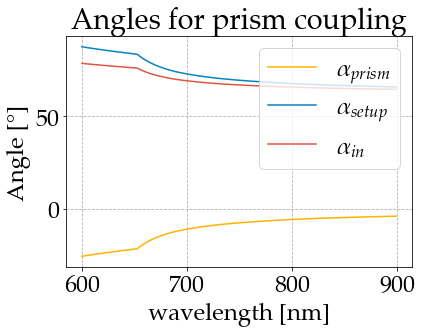

In [7]:
alpha1=[]
alpha=[]
alpha_in=[]
lamb=range(600, 900, 1)

for lm in lamb:
    alpha1.append(spr_info(lm*1e-9)[0])
    alpha.append(spr_info(lm*1e-9)[1])
    alpha_in.append(spr_info(lm*1e-9)[2])



fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('Angles for prism coupling')
axes.set_xlabel('wavelength [nm]')
axes.set_ylabel('Angle [°]')
# axes.set_yscale('log')

name='test_01'
axes.plot(lamb, alpha1, color=yellow, linewidth=1.5, label='$\\alpha_{prism}$')
axes.plot(lamb, alpha, color=blue, linewidth=1.5, label='$\\alpha_{setup}$')
axes.plot(lamb, alpha_in, color=red, linewidth=1.5, label='$\\alpha_{in}$')

axes.legend(loc=1)

# fig.savefig(folder + 'wavelengths_and_angles.png', dpi=500)

In [7]:
# prism_angle(62/180*m.pi)
setup_angle(66.6/180*m.pi)

68.9556126322633

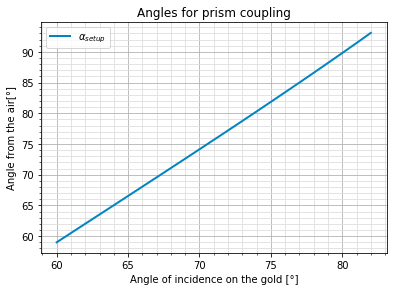

In [8]:

angles_4=range(60, 83, 1)
alpha1=[]
alpha=[]
for a in angles_4:
#     print(a)
    alpha1.append(prism_angle(a/180*m.pi))
    alpha.append(setup_angle(a/180*m.pi))


fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('Angles for prism coupling')
axes.set_xlabel('Angle of incidence on the gold [°]')
axes.set_ylabel('Angle from the air[°]')

axes.plot(angles_4, alpha, color=blue, linewidth=2, label='$\\alpha_{setup}$')
axes.legend(loc=2)
axes.grid(linestyle='-')
axes.grid(linestyle='-', which='minor', color='#dddddd')
axes.xaxis.set_minor_locator(plt.MaxNLocator(26))
axes.yaxis.set_minor_locator(plt.MaxNLocator(41))

# fig.savefig(folder + 'angle_of_incidence_to_setup.png', dpi=300)

In [20]:
epd = 1.332**2
betas=[]
# lamda=[i*1e-9 for i in range(400, 1000)]
lamda=np.arange(650e-9, 1400e-9, 5e-9)
for l in lamda:
    betas.append(betavector(l))
    
epd = 1.55**2
betas_glass=[]
for l in lamda:
    betas_glass.append(betavector(l))

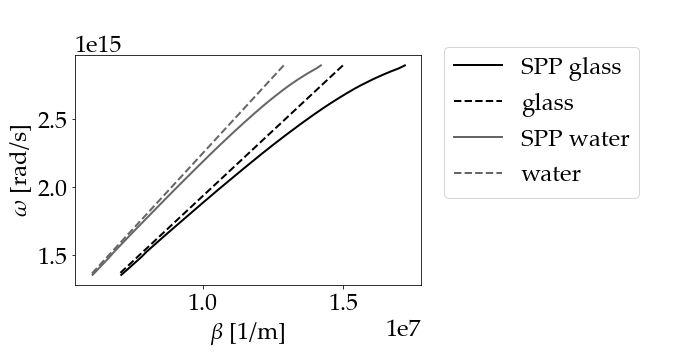

In [26]:
omega=2*m.pi*c.c/lamda
k_air=omega/c.c

ll=600e-9
k_grating=[2*m.pi/ll]*len(lamda)


fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# axes.grid(linestyle='--')
# axes.set_title('Dispersion')
axes.set_xlabel('$\\beta$ [1/m]')
axes.set_ylabel('$\\omega$ [rad/s]')
# axes.set_yscale('log')

name='test_01'

axes.plot(np.real(betas_glass), omega, color='black', linewidth=2, label='SPP glass')
axes.plot(k_air*1.55, omega, color='black', linewidth=2, label='glass', ls='--')
axes.plot(np.real(betas), omega, color='#666666', linewidth=2, label='SPP water')
axes.plot(k_air*1.332, omega, color='#666666', linewidth=2, label='water', ls='--')

# axes.plot(k_grating, omega, color=red, linewidth=2, label='grating')
# axes.plot([0.5*k for k in k_grating], omega, color=red, linewidth=2, label='grating')


lgd = fig.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

# fig.savefig(folder + 'plot_dispersion_relation_glass.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [117]:
2*m.pi/4e15*c.c

4.7091289182721325e-07

In [7]:
# spr_info(500e-9, p=True)
# spr_info(550e-9, p=True)
spr_info(600e-9, p=True)
spr_info(650e-9, p=True)
spr_info(750e-9, p=True)
spr_info(900e-9, p=True)

600.0
(15500704.893722242-307322.67041603563j)
n = 1.480-0.029j
lambda_p= 405.348
L= -1.627 um
z= 0.146 um
alfa_1= -25.555 °
alfa= 87.555 °
alfa_in= 78.600 °
650.0
(14173683.88354875-165776.25479662887j)
n = 1.466-0.017j
lambda_p= 443.299
L= -3.016 um
z= 0.167 um
alfa_1= -21.707 °
alfa= 83.707 °
alfa_in= 76.179 °
750.0
(11639602.45909309-39096.504382631145j)
n = 1.389-0.005j
lambda_p= 539.811
L= -12.789 um
z= 0.297 um
alfa_1= -7.476 °
alfa= 69.476 °
alfa_in= 66.943 °
900.0
(9520257.308616376-17553.854465031607j)
n = 1.364-0.003j
lambda_p= 659.981
L= -28.484 um
z= 0.475 um
alfa_1= -3.880 °
alfa= 65.880 °
alfa_in= 64.568 °


(-3.8796216045602185, 65.87962160456021, 64.56818282445177)

In [15]:
9.982*2

19.964

In [8]:
spr_info(602e-9, p=True)
spr_info(608e-9, p=True)
spr_info(641.5e-9, p=True)
spr_info(655e-9, p=True)
spr_info(737e-9, p=True)
spr_info(722.5e-9, p=True)

602.0
(15443135.286430925-300244.2973787777j)
n = 1.480-0.029j
lambda_p= 406.859
L= -1.665 um
z= 0.147 um
alfa_1= -25.377 °
alfa= 87.377 °
alfa_in= 78.489 °
608.0
(15272808.281915696-279818.7529318284j)
n = 1.478-0.027j
lambda_p= 411.397
L= -1.787 um
z= 0.150 um
alfa_1= -24.857 °
alfa= 86.857 °
alfa_in= 78.163 °
641.5
(14383706.699992973-185278.30664649245j)
n = 1.469-0.019j
lambda_p= 436.827
L= -2.699 um
z= 0.164 um
alfa_1= -22.283 °
alfa= 84.283 °
alfa_in= 76.544 °
655.0
(14015636.452699969-150576.84318299385j)
n = 1.461-0.016j
lambda_p= 448.298
L= -3.321 um
z= 0.172 um
alfa_1= -20.446 °
alfa= 82.446 °
alfa_in= 75.376 °
737.0
(11881704.048147324-43562.33227453323j)
n = 1.394-0.005j
lambda_p= 528.812
L= -11.478 um
z= 0.281 um
alfa_1= -8.116 °
alfa= 70.116 °
alfa_in= 67.365 °
722.5
(12170854.605504615-50089.09113638486j)
n = 1.400-0.006j
lambda_p= 516.248
L= -9.982 um
z= 0.264 um
alfa_1= -9.000 °
alfa= 71.000 °
alfa_in= 67.947 °


(-9.000224353164917, 71.00022435316492, 67.94660155044792)

In [12]:
90-m.acos(11639602/1.51/2/m.pi*750e-9)/m.pi*180

66.94304482495698

In [13]:
.94*60


56.4

In [14]:
m.atan(15500704/(2*m.pi/600e-9))/m.pi*180

55.95780126657507

In [15]:
ML_lm=[i for i in range(600, 901)]
ML_optimal_angle=[77.2000000000000, 77.2000000000000, 77.2000000000000, 77.2000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.3000000000000, 77.2000000000000, 77.2000000000000, 77.2000000000000, 77.2000000000000, 77.1000000000000, 77.1000000000000, 77.1000000000000, 77, 77, 76.9000000000000, 76.9000000000000, 76.8000000000000, 76.7000000000000, 76.7000000000000, 76.6000000000000, 76.5000000000000, 76.5000000000000, 76.4000000000000, 76.3000000000000, 76.2000000000000, 76.1000000000000, 76, 75.9000000000000, 75.8000000000000, 75.7000000000000, 75.6000000000000, 75.4000000000000, 75.3000000000000, 75.2000000000000, 75, 74.9000000000000, 74.8000000000000, 74.6000000000000, 74.5000000000000, 74.3000000000000, 74.2000000000000, 74, 73.9000000000000, 73.7000000000000, 73.6000000000000, 73.4000000000000, 73.3000000000000, 73.1000000000000, 73, 72.8000000000000, 72.7000000000000, 72.5000000000000, 72.4000000000000, 72.2000000000000, 72.1000000000000, 72, 71.8000000000000, 71.7000000000000, 71.5000000000000, 71.4000000000000, 71.3000000000000, 71.2000000000000, 71, 70.9000000000000, 70.8000000000000, 70.7000000000000, 70.6000000000000, 70.5000000000000, 70.4000000000000, 70.3000000000000, 70.2000000000000, 70.1000000000000, 70, 69.9000000000000, 69.8000000000000, 69.7000000000000, 69.6000000000000, 69.6000000000000, 69.5000000000000, 69.4000000000000, 69.3000000000000, 69.3000000000000, 69.2000000000000, 69.1000000000000, 69.1000000000000, 69, 69, 68.9000000000000, 68.8000000000000, 68.8000000000000, 68.7000000000000, 68.7000000000000, 68.6000000000000, 68.6000000000000, 68.5000000000000, 68.5000000000000, 68.4000000000000, 68.4000000000000, 68.3000000000000, 68.3000000000000, 68.2000000000000, 68.2000000000000, 68.2000000000000, 68.1000000000000, 68.1000000000000, 68, 68, 68, 67.9000000000000, 67.9000000000000, 67.8000000000000, 67.8000000000000, 67.8000000000000, 67.7000000000000, 67.7000000000000, 67.7000000000000, 67.6000000000000, 67.6000000000000, 67.6000000000000, 67.5000000000000, 67.5000000000000, 67.5000000000000, 67.4000000000000, 67.4000000000000, 67.4000000000000, 67.3000000000000, 67.3000000000000, 67.3000000000000, 67.2000000000000, 67.2000000000000, 67.2000000000000, 67.1000000000000, 67.1000000000000, 67.1000000000000, 67.1000000000000, 67, 67, 67, 66.9000000000000, 66.9000000000000, 66.9000000000000, 66.9000000000000, 66.8000000000000, 66.8000000000000, 66.8000000000000, 66.7000000000000, 66.7000000000000, 66.7000000000000, 66.7000000000000, 66.6000000000000, 66.6000000000000, 66.6000000000000, 66.6000000000000, 66.5000000000000, 66.5000000000000, 66.5000000000000, 66.5000000000000, 66.4000000000000, 66.4000000000000, 66.4000000000000, 66.4000000000000, 66.4000000000000, 66.3000000000000, 66.3000000000000, 66.3000000000000, 66.3000000000000, 66.2000000000000, 66.2000000000000, 66.2000000000000, 66.2000000000000, 66.2000000000000, 66.1000000000000, 66.1000000000000, 66.1000000000000, 66.1000000000000, 66, 66, 66, 66, 66, 66, 65.9000000000000, 65.9000000000000, 65.9000000000000, 65.9000000000000, 65.9000000000000, 65.8000000000000, 65.8000000000000, 65.8000000000000, 65.8000000000000, 65.8000000000000, 65.8000000000000, 65.7000000000000, 65.7000000000000, 65.7000000000000, 65.7000000000000, 65.7000000000000, 65.7000000000000, 65.6000000000000, 65.6000000000000, 65.6000000000000, 65.6000000000000, 65.6000000000000, 65.6000000000000, 65.5000000000000, 65.5000000000000, 65.5000000000000, 65.5000000000000, 65.5000000000000, 65.5000000000000, 65.5000000000000, 65.4000000000000, 65.4000000000000, 65.4000000000000, 65.4000000000000, 65.4000000000000, 65.4000000000000, 65.4000000000000, 65.4000000000000, 65.3000000000000, 65.3000000000000, 65.3000000000000, 65.3000000000000, 65.3000000000000, 65.3000000000000, 65.3000000000000, 65.3000000000000, 65.2000000000000, 65.2000000000000, 65.2000000000000, 65.2000000000000, 65.2000000000000, 65.2000000000000, 65.2000000000000, 65.2000000000000, 65.2000000000000, 65.1000000000000, 65.1000000000000, 65.1000000000000, 65.1000000000000, 65.1000000000000, 65.1000000000000, 65.1000000000000, 65.1000000000000, 65.1000000000000, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.9000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.8000000000000, 64.7000000000000, 64.7000000000000, 64.7000000000000, 64.7000000000000, 64.7000000000000, 64.7000000000000, 64.7000000000000]

In [16]:
calibration_wls=[753, 662, 617, 836]
calibration_angles=[70, 75, 80, 68]


calibration_wls=[845, 764, 709, 677, 656, 635, 621, 610, 604]
calibration_angles=[i for i in range(68, 86, 2)]

calibration_wls.extend(2*calibration_wls)
calibration_angles.extend([i+0.5 for i in range(68, 86, 2)])
calibration_angles.extend([i-0.5 for i in range(68, 86, 2)])

# calibration_wls=[662, 662, 662]
# calibration_angles=[75, 75.5, 74.5]

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Bukacek/OneDrive - UFE/thesis/diplomka/prism_setup/both_angles_water_calibration.png'

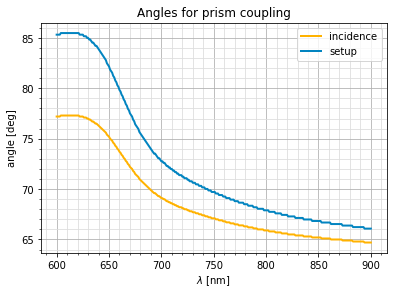

In [17]:

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='-')
axes.grid(linestyle='-', which='minor', color='#dddddd')
axes.set_title('Angles for prism coupling')
axes.set_xlabel('$\\lambda$ [nm]')
axes.set_ylabel('angle [deg]')
axes.xaxis.set_minor_locator(plt.MaxNLocator(36))
axes.yaxis.set_minor_locator(plt.MaxNLocator(26))

name='test_01'
axes.plot(ML_lm, ML_optimal_angle, color=yellow, linewidth=2, label='incidence')
axes.plot(ML_lm, [setup_angle(ml/180*m.pi) for ml in ML_optimal_angle], color=blue, linewidth=2, label='setup')
# axes.scatter(calibration_wls, calibration_angles, color=red, linewidth=2, label='calibration data')




axes.legend(loc=1)
fig.savefig(folder + 'both_angles_water_calibration.png', dpi=300)

In [18]:
betas_prism=[2*m.pi/ML_lm[i]*1e9*1.51*m.sin(ML_optimal_angle[i]/180*m.pi) for i in range(len(ML_lm))]

In [19]:
2*m.pi/betas_prism[-1]*1e9

659.2611374811524

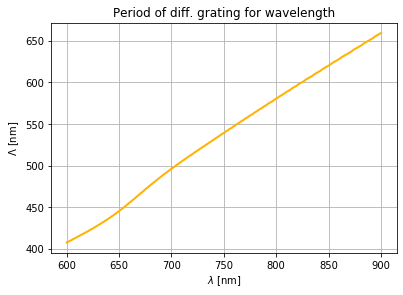

In [20]:

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='-')
axes.grid(linestyle='-', which='minor', color='#dddddd')
axes.set_title('Period of diff. grating for wavelength')
axes.set_xlabel('$\\lambda$ [nm]')
axes.set_ylabel('$\\Lambda$ [nm]')


name='test_01'
axes.plot(ML_lm, [2*m.pi/b*1e9 for b in betas_prism], color=yellow, linewidth=2)

# fig.savefig(folder + 'both_angles_water_calibration.png', dpi=300)

# Pythagoras and Plasmonics

$k_i^2 = \beta^2 - k_0^2\epsilon_i$

In [21]:
eps = 1.33
br=15500704.893722242
bi=307322.67041603563

k0r=2*m.pi/600e-9
k0i = bi*-10
bi=-k0r/br
# k0i=bi*100

In [22]:
# kp = kpr + 1j*kpi
k0 = k0r + 1j*k0i
b = br + 1j*bi

In [23]:
kp=(b**2-k0**2*eps)**0.5

In [24]:
print(k0)
print(b)
print(kp)


(10471975.511965977-3073226.7041603564j)
(15500704.893722242-0.6755805999640125j)
(11045350.408297792+3875210.094269414j)


In [25]:
1/kp.real*1e9

90.53583300071244

## Range of angles

In [21]:
lm = 750e-9
k0 = 2*m.pi/lm
epq = 1.33
b = betavector(lm)
K = 2*m.pi/453e-9

In [28]:
print(m.asin(b.real/(k0*1.55))/m.pi*180)

63.6850895724502


In [18]:
print(b)
print(K)
m.asin((b-K)/k0/epq)/m.pi*180

(13048216.629163919-80809.53091984974j)
13870166.24101454


C:\Users\bukacek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


-3.8632785068960223

C:\Users\bukacek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


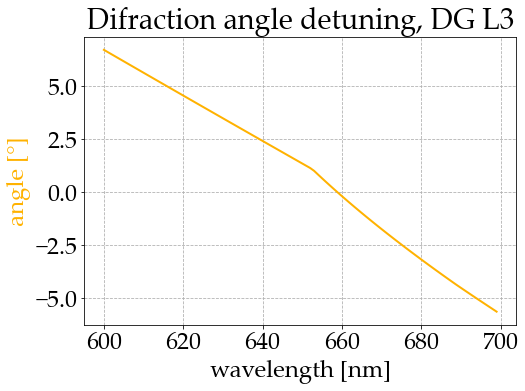

In [20]:
wls=[i/1e9 for i in range(600, 700, 1)]

angles = [m.asin((betavector(lm)-K)/(2*m.pi/lm)/epq)/m.pi*180 for lm in wls]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.grid(linestyle='--')
axes.set_title('Difraction angle detuning, DG L3')
axes.set_xlabel('wavelength [nm]')
axes.set_ylabel('angle [°]', color=yellow)



axes.plot([w*1e9 for w in wls], angles, color=yellow, linewidth=2)

fig.savefig(folder + 'angle_detuning.png', dpi=300, bbox_inches='tight')

In [10]:
m.asin(0.16)/m.pi*180

9.206896221345902